# Machine Learning for Data Science  
# Supervised, Semi-Supervised, and Unsupervised Learning | Active Learning Using Support Vector Machines

## Rajnandini Thopte 




### 1. Supervised, Semi-Supervised, and Unsupervised Learning

#### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set from:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29. Download the data in https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data, which has IDs, classes (Benign=B, Malignant=M), and 30 attributes. This data has two output classes.

In [194]:
import pandas as pd
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import softmax

In [195]:
# Define an empty dictionary to store the summary
summary = {}

# Load the wdbc data file and header file
wdbc_data = "../data/HW8_data/wdbc.data"
wdbc_names = "../data/HW8_data/wdbc.names"

# Read the wdbc data file into a pandas dataframe
wdbc_data = pd.read_csv(wdbc_data, header=None)

# Create column names for the dataframe
temp = []
for i in range(len(wdbc_data.columns)):
    if i == 0:
        temp.append('id')
    elif i == 1:
        temp.append('label')
    else:
        temp.append(f'col{i}')
wdbc_data.columns = temp

# Replace label 'M' (malignant) with 1 and label 'B' (benign) with 0
wdbc_data.replace({'M': 1, 'B': 0}, inplace=True)

# Return the modified dataframe
wdbc_data


,id,label,col2,col3,col4,col5,col6,col7,col8,col9,...,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [196]:
# Count the number of occurrences of each label in the 'label' column of the 'wdbc_data' dataframe
wdbc_data['label'].value_counts()

0    357
1    212
Name: label, dtype: int64

In [197]:
def custom_train_test_split(data, random_state, test_size=0.2):
    # Set a random seed for reproducibility
    np.random.seed(random_state)

    # Get the test indices for benign and malignant cases
    b_idx = np.where(data['label'] == 0)[0]
    b_test_idx = np.random.choice(b_idx, size=int(len(b_idx) * test_size), replace=False)

    m_idx = np.where(data['label'] == 1)[0]
    m_test_idx = np.random.choice(m_idx, size=int(len(m_idx) * test_size), replace=False)

    # Combine the test indices for both types of cases
    test_idx = np.concatenate([b_test_idx, m_test_idx])

    # Get the training indices by excluding the test indices
    train_idx = np.setdiff1d(np.arange(data.shape[0]), test_idx)

    # Split the data into training and testing sets
    train_data = data.iloc[train_idx, :]
    test_data = data.iloc[test_idx, :]

    # Return the training and testing sets
    return train_data.iloc[:, 2:], test_data.iloc[:, 2:], train_data.iloc[:, 1], test_data.iloc[:, 1]

# Use the custom train/test split function to split the data into training and testing sets
x_train, x_test, y_train, y_test = custom_train_test_split(wdbc_data, random_state=0)


In [198]:
x_train

,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,...,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,15.470,23.75,103.40,741.6,0.17910,0.52490,0.5355,0.1741,0.3985,0.12440
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.3784,0.1932,0.3063,0.08368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.2542,0.2929,0.09873
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


In [199]:
x_test

,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,...,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31
49,13.490,22.30,86.91,561.0,0.08752,0.07698,0.04751,0.033840,0.1809,0.05718,...,15.15,31.82,99.00,698.8,0.1162,0.17110,0.228200,0.128200,0.2871,0.06917
285,12.580,18.40,79.83,489.0,0.08393,0.04216,0.00186,0.002924,0.1697,0.05855,...,13.50,23.08,85.56,564.1,0.1038,0.06624,0.005579,0.008772,0.2505,0.06431
495,14.870,20.21,96.12,680.9,0.09587,0.08345,0.06824,0.049510,0.1487,0.05748,...,16.01,28.48,103.90,783.6,0.1216,0.13880,0.170000,0.101700,0.2369,0.06599
391,8.734,16.84,55.27,234.3,0.10390,0.07428,0.00000,0.000000,0.1985,0.07098,...,10.17,22.80,64.01,317.0,0.1460,0.13100,0.000000,0.000000,0.2445,0.08865
187,11.710,17.19,74.68,420.3,0.09774,0.06141,0.03809,0.032390,0.1516,0.06095,...,13.01,21.39,84.42,521.5,0.1323,0.10400,0.152100,0.109900,0.2572,0.07097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,18.490,17.52,121.30,1068.0,0.10120,0.13170,0.14910,0.091830,0.1832,0.06697,...,22.75,22.88,146.40,1600.0,0.1412,0.30890,0.353300,0.166300,0.2510,0.09445
352,25.730,17.46,174.20,2010.0,0.11490,0.23630,0.33680,0.191300,0.1956,0.06121,...,33.13,23.58,229.30,3234.0,0.1530,0.59370,0.645100,0.275600,0.3690,0.08815
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.149600,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.1491,0.75840,0.678000,0.290300,0.4098,0.12840
91,15.370,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.074830,0.1717,0.06097,...,16.43,25.84,107.50,830.9,0.1257,0.19970,0.284600,0.147600,0.2556,0.06828


In [200]:
y_train.value_counts()

0    286
1    170
Name: label, dtype: int64

In [201]:
y_test.value_counts()

0    71
1    42
Name: label, dtype: int64

#### (b) Monte-Carlo Simulation:
Repeat the following procedures for supervised, unsupervised, and semi-supervised learning M = 30 times, and use randomly selected train and test data (make sure you use 20% of both the positve and negative classes as the test set). Then compare the average scores (accuracy, precision, recall, F1-score, and AUC) that you obtain from each algorithm.

In [202]:
def scale_data(x_train, x_test):    
    # Instantiate a Normalizer object
    normalizer = Normalizer()
    
    # Apply normalization to the training data
    x_train_scaled = normalizer.fit_transform(x_train)
    
    # Apply normalization to the test data
    x_test_scaled = normalizer.fit_transform(x_test)
    
    # Convert the normalized data to Pandas DataFrames and return them
    return pd.DataFrame(x_train_scaled), pd.DataFrame(x_test_scaled)


# Use the function to get the normalized training and testing data
x_train_scaled, x_test_scaled = scale_data(x_train, x_test)


In [203]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.007925,0.004573,0.054099,0.440986,0.000052,0.000122,0.000132,0.000065,0.000107,0.000035,...,0.011181,0.007635,0.081325,0.889462,0.000071,0.000293,0.000314,0.000117,0.000203,0.000052
1,0.016325,0.029133,0.110899,0.551922,0.000204,0.000406,0.000345,0.000150,0.000371,0.000139,...,0.021314,0.037881,0.141333,0.811515,0.000300,0.001238,0.000982,0.000368,0.000949,0.000247
2,0.009883,0.006985,0.065808,0.631774,0.000049,0.000065,0.000096,0.000051,0.000088,0.000029,...,0.010979,0.008120,0.074137,0.767189,0.000067,0.000100,0.000195,0.000079,0.000115,0.000037
3,0.013945,0.017586,0.092486,0.534398,0.000143,0.000190,0.000177,0.000091,0.000234,0.000085,...,0.017328,0.026602,0.115818,0.830664,0.000201,0.000588,0.000600,0.000195,0.000446,0.000139
4,0.009483,0.010382,0.062147,0.540411,0.000049,0.000057,0.000059,0.000038,0.000093,0.000030,...,0.011889,0.014373,0.079607,0.834520,0.000075,0.000134,0.000197,0.000100,0.000159,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.009181,0.011011,0.062755,0.591130,0.000048,0.000098,0.000139,0.000065,0.000094,0.000030,...,0.010660,0.012907,0.078598,0.798267,0.000062,0.000184,0.000290,0.000112,0.000129,0.000043
452,0.008541,0.008870,0.056256,0.585933,0.000044,0.000046,0.000097,0.000055,0.000068,0.000022,...,0.010082,0.010459,0.065804,0.803033,0.000056,0.000084,0.000163,0.000088,0.000082,0.000028
453,0.009344,0.013114,0.060903,0.585355,0.000045,0.000048,0.000067,0.000045,0.000081,0.000026,...,0.010997,0.017756,0.071951,0.803528,0.000054,0.000089,0.000149,0.000076,0.000119,0.000031
454,0.011644,0.019696,0.075966,0.601905,0.000059,0.000072,0.000065,0.000037,0.000112,0.000040,...,0.013313,0.023933,0.088872,0.788417,0.000080,0.000217,0.000239,0.000099,0.000156,0.000055


In [204]:
x_test_scaled

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.014872,0.024585,0.095817,0.618492,0.000096,0.000085,0.000052,0.000037,0.000199,0.000063,...,0.016703,0.035081,0.109146,0.770414,0.000128,0.000189,0.000252,0.000141,0.000317,0.000076
1,0.016623,0.024313,0.105484,0.646143,0.000111,0.000056,0.000002,0.000004,0.000224,0.000077,...,0.017838,0.030497,0.113055,0.745377,0.000137,0.000088,0.000007,0.000012,0.000331,0.000085
2,0.014179,0.019271,0.091652,0.649252,0.000091,0.000080,0.000065,0.000047,0.000142,0.000055,...,0.015266,0.027156,0.099071,0.747178,0.000116,0.000132,0.000162,0.000097,0.000226,0.000063
3,0.021543,0.041537,0.136327,0.577915,0.000256,0.000183,0.000000,0.000000,0.000490,0.000175,...,0.025085,0.056238,0.157884,0.781899,0.000360,0.000323,0.000000,0.000000,0.000603,0.000219
4,0.017215,0.025271,0.109788,0.617888,0.000144,0.000090,0.000056,0.000048,0.000223,0.000090,...,0.019126,0.031446,0.124107,0.766663,0.000194,0.000153,0.000224,0.000162,0.000378,0.000104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.009551,0.009050,0.062659,0.551685,0.000052,0.000068,0.000077,0.000047,0.000095,0.000035,...,0.011752,0.011819,0.075624,0.826495,0.000073,0.000160,0.000183,0.000086,0.000130,0.000049
109,0.006732,0.004568,0.045578,0.525899,0.000030,0.000062,0.000088,0.000050,0.000051,0.000016,...,0.008668,0.006170,0.059994,0.846148,0.000040,0.000155,0.000169,0.000072,0.000097,0.000023
110,0.008509,0.010719,0.057571,0.528913,0.000046,0.000114,0.000100,0.000060,0.000097,0.000030,...,0.010764,0.013507,0.071208,0.842791,0.000060,0.000306,0.000274,0.000117,0.000165,0.000052
111,0.013776,0.020399,0.089808,0.652673,0.000082,0.000093,0.000101,0.000067,0.000154,0.000055,...,0.014726,0.023160,0.096350,0.744721,0.000113,0.000179,0.000255,0.000132,0.000229,0.000061


#### i. Supervised Learning: 
Train an L1-penalized SVM to classify the data. Use 5 fold cross validation to choose the penalty parameter. Use normalized data. Report the average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [205]:
# Calculate and print accuracy score
def calculate_accuracy_score(true_labels, predicted_labels):
    calculated_accuracy_score = accuracy_score(true_labels, predicted_labels)
    print(f'Accuracy Score is: {round(calculated_accuracy_score, 4)}')
    print("\n")

# Compute and display confusion matrix
def compute_and_display_confusion_matrix(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print(f'Confusion Matrix is: \n{conf_matrix}')
    print("\n")

# Visualize ROC curve
def visualize_roc_curve(true_labels, predicted_probabilities, plot_title):
    plt.style.use('seaborn-whitegrid')
    fig, axes = plt.subplots(figsize=(10, 6))
    axes.set_title("ROC Curve for {}".format(plot_title), fontsize=16, fontweight='bold')
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities, pos_label=1)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label="ROC Curve Area: {:.4f}".format(roc_auc), linewidth=2)
    axes.plot([0, 1], [0, 1], "--", color='gray', linewidth=1)
    axes.set_xlabel("False Positive Rate", fontsize=14)
    axes.set_ylabel("True Positive Rate", fontsize=14)
    axes.tick_params(axis='both', labelsize=12)
    axes.legend(fontsize=12)
    plt.show()



# Summarize evaluation metrics
def summarize_evaluation_metrics(true_labels, predicted_labels, predicted_probabilities, plot_title):
    print('-'*60)
    print(f"Model Summary for {plot_title}")
    print('-'*60)
    # Calculate and print accuracy score
    calculate_accuracy_score(true_labels, predicted_labels)
    # Compute and display confusion matrix
    compute_and_display_confusion_matrix(true_labels, predicted_labels)
    # Visualize ROC curve
    visualize_roc_curve(true_labels, predicted_probabilities, plot_title)



# Evaluate metrics based on classification report
def evaluate_metrics(data_y, data_y_pred, data_y_pred_prob, data_report):
    # Calculate false positive rate, true positive rate, and thresholds for ROC curve
    fpr, tpr, thresholds = roc_curve(data_y, data_y_pred_prob, pos_label=1)
    return {
        'acc' : data_report['accuracy'],
        'precision' : data_report['weighted avg']['precision'],
        'recall' : data_report['weighted avg']['recall'],
        'f1-score' : data_report['weighted avg']['f1-score'],
        'auc' : round(auc(fpr, tpr), 4)
    }

# Predict and evaluate model based on given classifier and data
def predict_and_evaluate_model(clf, data_x, data_y):
    # Get decision function scores and predicted labels
    y_data_pred_prob = clf.decision_function(data_x)
    y_data_pred = clf.predict(data_x)
    # Generate classification report and evaluate metrics
    data_report = classification_report(data_y, y_data_pred, output_dict=True)
    tmp_data_res = evaluate_metrics(data_y, y_data_pred, y_data_pred_prob, data_report)
    return {
        'tmp_data_res': tmp_data_res,
        'y_data_pred': y_data_pred,
        'y_data_pred_prob': y_data_pred_prob,
    }

# Summarize results by averaging all metrics for training and test sets
def summarize_results(train_df, test_df):
    print('-'*60)
    print("Averaging all metrics")
    print('-'*60)
    # Calculate mean of each metric for the training set
    train_resdf = train_df.apply(lambda x: x.mean(), axis=0)
    # Calculate mean of each metric for the test set
    test_resdf = test_df.apply(lambda x: x.mean(), axis=0)
    # Combine the results for training and test sets
    data = [train_resdf, test_resdf]
    summary = pd.concat(data, axis=1)
    # Transpose the summary dataframe for better display
    summary = summary.T
    # Set the index for the summary dataframe
    summary = summary.set_index(pd.Series(['training', 'test']))
    # Print the summary dataframe
    print(summary)
    return summary


In [207]:
# Function for Data Splitting and Normalization
def split_and_normalize_data(data, random_state):
    x_train, x_test, y_train, y_test = custom_train_test_split(data, random_state=random_state)
    x_train_normalized, x_test_normalized = scale_data(x_train, x_test)
    return x_train_normalized, x_test_normalized, y_train, y_test

# Function for Algorithm Choice and Training
def train_algorithm(x_train, y_train, algo, k_folds, kwargs):
    if algo == 'supervised-svm':
        kwargs['cv'] = StratifiedKFold(k_folds, random_state=i, shuffle=True)
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **kwargs)
    elif algo == 'semi-supervised-svm':
        clf = custom_semi_supervised_svm(x_train, y_train, kwargs)
    else:
        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **kwargs)
    clf.fit(x_train, y_train)
    return clf

# Function for Results Evaluation and Printing
def evaluate_and_print_results(iteration, train_report, test_report):
    train_accuracy = train_report['tmp_data_res']['acc']
    test_accuracy = test_report['tmp_data_res']['acc']
    print(f'Iteration: {iteration + 1}')
    print(f'Training Accuracy: {round(train_accuracy, 4)}')
    print(f'Testing Accuracy: {round(test_accuracy, 4)}')
    print("====================================================================================================")

# Updated Monte Carlo Simulation Function
def run_monte_carlo_svm_analysis(data, iterations, algo):
    end = 20 if algo == 'supervised-svm' else 10 if algo == 'semi-supervised-svm' else 20
    tuned_params = {'C': np.logspace(-2, 7, end)}
    kwargs = {'param_grid': tuned_params, 'scoring': 'f1_weighted', 'n_jobs': -1, 'verbose': 0}
    k_folds = 5
    cols = ['acc', 'precision', 'recall', 'f1-score', 'auc']
    train_df = pd.DataFrame(columns=cols)
    test_df = pd.DataFrame(columns=cols)

    for i in range(iterations):
        x_train, x_test, y_train, y_test = split_and_normalize_data(data, random_state=i)
        clf = train_algorithm(x_train, y_train, algo, k_folds, kwargs)
        
        train_report = predict_and_evaluate_model(clf, x_train, y_train)
        train_df = train_df.append(train_report['tmp_data_res'], ignore_index=True)

        test_report = predict_and_evaluate_model(clf, x_test, y_test)
        test_df = test_df.append(test_report['tmp_data_res'], ignore_index=True)
        
        evaluate_and_print_results(i, train_report, test_report)

    summarize_evaluation_metrics(y_train, train_report['y_data_pred'], train_report['y_data_pred_prob'], "Training")
    summarize_evaluation_metrics(y_test, test_report['y_data_pred'], test_report['y_data_pred_prob'], "Testing")

    summary = summarize_results(train_df, test_df)
    return summary


Iteration: 1
Training Accuracy: 0.9934
Testing Accuracy: 0.9646
Iteration: 2
Training Accuracy: 0.9781
Testing Accuracy: 0.9735
Iteration: 3
Training Accuracy: 0.9759
Testing Accuracy: 0.9204
Iteration: 4
Training Accuracy: 0.9956
Testing Accuracy: 0.9646
Iteration: 5
Training Accuracy: 0.9978
Testing Accuracy: 0.9558
Iteration: 6
Training Accuracy: 0.9868
Testing Accuracy: 0.9469
Iteration: 7
Training Accuracy: 0.9825
Testing Accuracy: 0.9558
Iteration: 8
Training Accuracy: 0.9846
Testing Accuracy: 0.9558
Iteration: 9
Training Accuracy: 0.9912
Testing Accuracy: 0.9646
Iteration: 10
Training Accuracy: 0.9781
Testing Accuracy: 0.9912
Iteration: 11
Training Accuracy: 0.9825
Testing Accuracy: 0.9558
Iteration: 12
Training Accuracy: 0.9825
Testing Accuracy: 0.9912
Iteration: 13
Training Accuracy: 0.9803
Testing Accuracy: 0.9823
Iteration: 14
Training Accuracy: 0.9846
Testing Accuracy: 0.9646
Iteration: 15
Training Accuracy: 0.9825
Testing Accuracy: 0.9558
Iteration: 16
Training Accuracy: 0

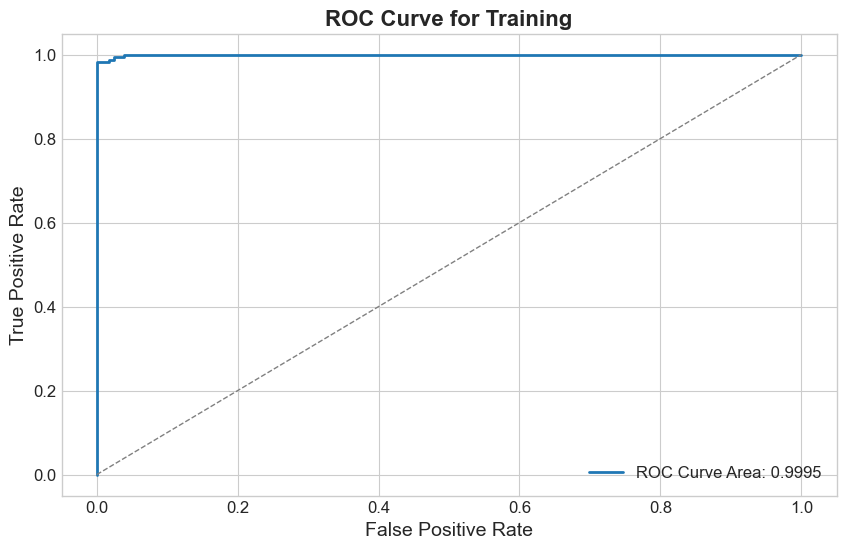

------------------------------------------------------------
Model Summary for Testing
------------------------------------------------------------
Accuracy Score is: 0.9292


Confusion Matrix is: 
[[69  2]
 [ 6 36]]




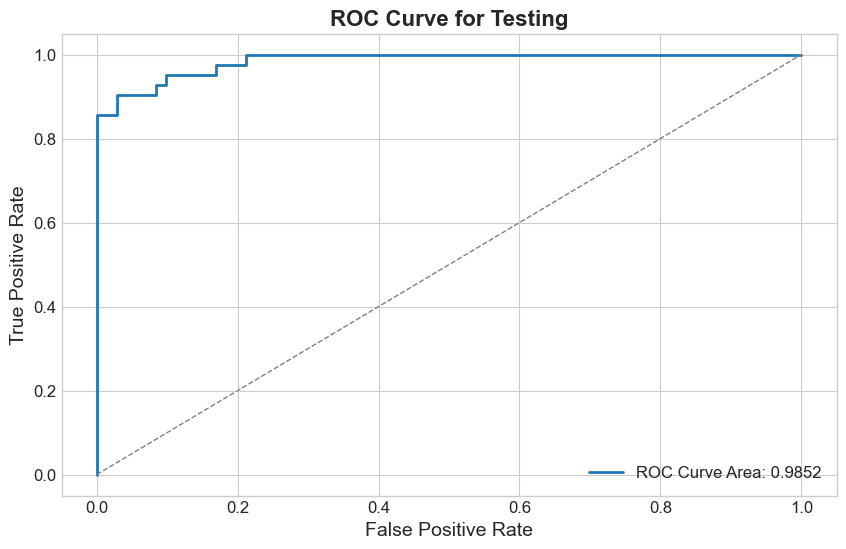

------------------------------------------------------------
Averaging all metrics
------------------------------------------------------------
               acc  precision    recall  f1-score       auc
training  0.984430   0.984458  0.984430  0.984413  0.998757
test      0.957817   0.958309  0.957817  0.957696  0.988910


,acc,precision,recall,f1-score,auc
training,0.984430,0.984458,0.984430,0.984413,0.998757
test,0.957817,0.958309,0.957817,0.957696,0.988910


In [208]:
algo = 'supervised-svm'
summary['Supervized L1 SVM'] = run_monte_carlo_svm_analysis(wdbc_data, 30, algo)
df = pd.DataFrame(summary['Supervized L1 SVM'])
df

#### ii. Semi-Supervised Learning/ Self-training: 
Select 50% of the positive class along with 50% of the negative class in the training set as labeled data and the rest as unlabelled data. You can select them randomly.
##### A. Train an L1-penalized SVM to classify the labeled data Use normalized data. Choose the penalty parameter using 5 fold cross validation.
##### B. Findt he unlabeled data point that is  the farthest to the decision boundary of the SVM. Let the SVM label it (ignore its true label), and add it to the labeled data, and retrain the SVM. Continue this process until all unlabeled data are used. Test the final SVM on the test data andthe average accuracy, precision, recall, F1-score, and AUC, for both training and test sets over your M runs. Plot the ROC and report the confusion matrix for training and testing in one of the runs.

In [210]:
from sklearn.utils import check_random_state

# Function to randomly select labeled indices for each class
def select_labeled_indices(training_labels, fraction=0.5, random_state=None):
    random_state = check_random_state(random_state)
    labeled_indices = []

    for class_label in np.unique(training_labels):
        class_indices, = np.where(training_labels == class_label)
        num_indices = round(len(class_indices) * fraction)
        selected_indices = random_state.choice(class_indices, num_indices, replace=False)
        labeled_indices.extend(selected_indices)

    return labeled_indices

# Function to split labeled and unlabeled data
def split_labeled_unlabeled_data(training_features, training_labels, labeled_indices):
    unlabeled_indices = [i for i in range(len(training_features)) if i not in labeled_indices]

    labeled_features = training_features.iloc[labeled_indices].to_numpy().tolist()
    labeled_labels = training_labels.iloc[labeled_indices].to_numpy().tolist()
    unlabeled_features = training_features.iloc[unlabeled_indices].to_numpy().tolist()
    unlabeled_labels = training_labels.iloc[unlabeled_indices].to_numpy().tolist()

    return labeled_features, labeled_labels, unlabeled_features, unlabeled_labels

# Function to train SVM using labeled data
def train_svm_with_labeled_data(labeled_features, labeled_labels, algorithm_settings):
    clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **algorithm_settings)
    clf.fit(labeled_features, labeled_labels)
    return clf

# Function to iteratively label unlabeled data
def label_unlabeled_data(clf, labeled_features, labeled_labels, unlabeled_features, unlabeled_labels):
    while len(unlabeled_features) > 0:
        scores = clf.decision_function(unlabeled_features)
        sorted_idx = sorted(range(len(unlabeled_features)), key=lambda x: abs(scores[x]))
        unlabeled_features = [unlabeled_features[i] for i in sorted_idx]
        unlabeled_labels = [unlabeled_labels[i] for i in sorted_idx]

        labeled_features.append(unlabeled_features.pop())
        labeled_labels.append(unlabeled_labels.pop())
        clf.best_estimator_.fit(labeled_features, labeled_labels)

    return clf

# Refactored custom_semi_supervised_svm function
def custom_semi_supervised_svm(training_features, training_labels, algorithm_settings, fraction=0.5, random_state=None):
    labeled_indices = select_labeled_indices(training_labels, fraction, random_state)
    labeled_features, labeled_labels, unlabeled_features, unlabeled_labels = split_labeled_unlabeled_data(
        training_features, training_labels, labeled_indices)

    clf = train_svm_with_labeled_data(labeled_features, labeled_labels, algorithm_settings)

    clf = label_unlabeled_data(clf, labeled_features, labeled_labels, unlabeled_features, unlabeled_labels)

    return clf


Iteration: 1
Training Accuracy: 0.9956
Testing Accuracy: 0.9735
Iteration: 2
Training Accuracy: 0.9781
Testing Accuracy: 0.9735
Iteration: 3
Training Accuracy: 0.989
Testing Accuracy: 0.9469
Iteration: 4
Training Accuracy: 0.9846
Testing Accuracy: 0.9646
Iteration: 5
Training Accuracy: 0.989
Testing Accuracy: 0.9646
Iteration: 6
Training Accuracy: 0.9846
Testing Accuracy: 0.9469
Iteration: 7
Training Accuracy: 0.9759
Testing Accuracy: 0.9735
Iteration: 8
Training Accuracy: 0.9912
Testing Accuracy: 0.9558
Iteration: 9
Training Accuracy: 0.9912
Testing Accuracy: 0.9735
Iteration: 10
Training Accuracy: 0.9759
Testing Accuracy: 0.9912
Iteration: 11
Training Accuracy: 0.9825
Testing Accuracy: 0.9558
Iteration: 12
Training Accuracy: 0.9846
Testing Accuracy: 0.9823
Iteration: 13
Training Accuracy: 0.9803
Testing Accuracy: 0.9823
Iteration: 14
Training Accuracy: 0.989
Testing Accuracy: 0.9646
Iteration: 15
Training Accuracy: 0.9846
Testing Accuracy: 0.9558
Iteration: 16
Training Accuracy: 0.99

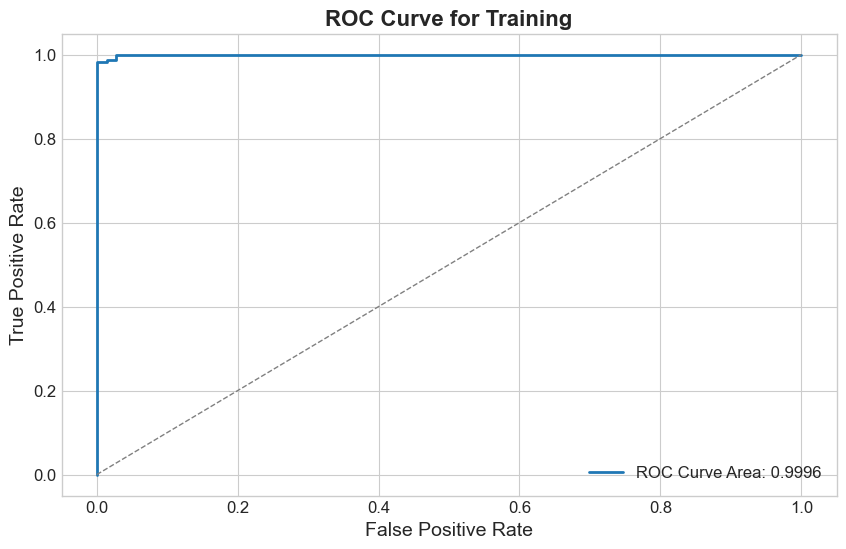

------------------------------------------------------------
Model Summary for Testing
------------------------------------------------------------
Accuracy Score is: 0.9381


Confusion Matrix is: 
[[69  2]
 [ 5 37]]




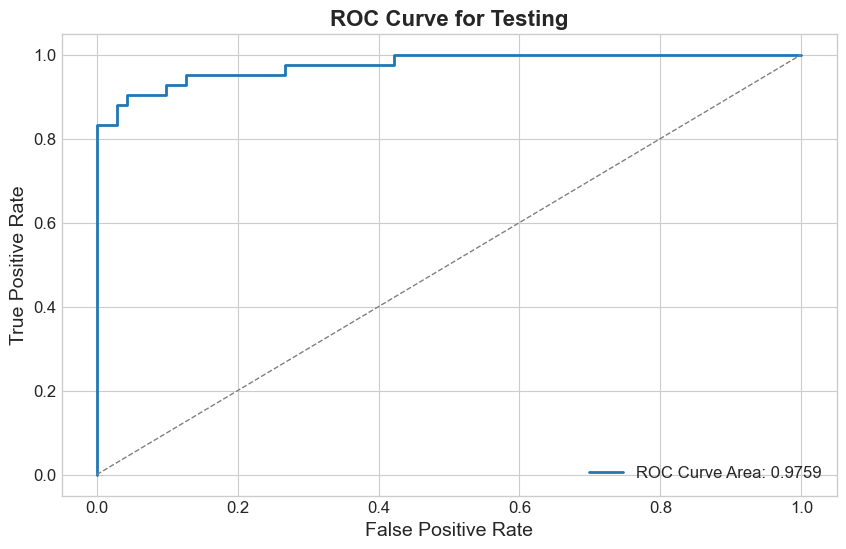

------------------------------------------------------------
Averaging all metrics
------------------------------------------------------------
               acc  precision    recall  f1-score       auc
training  0.984942   0.984971  0.984942  0.984921  0.998857
test      0.961947   0.962529  0.961947  0.961797  0.989120


,acc,precision,recall,f1-score,auc
training,0.984942,0.984971,0.984942,0.984921,0.998857
test,0.961947,0.962529,0.961947,0.961797,0.989120


In [211]:
# Run semi-supervised SVM and save results to summary
algorithm_type = 'semi-supervised-svm'
summary['Semi-Supervised L1 SVM'] = run_monte_carlo_svm_analysis(wdbc_data, 30, algorithm_type)

# Create a dataframe for the results of the semi-supervised SVM
df = pd.DataFrame(summary['Semi-Supervised L1 SVM'])
df


#### iii. Unsupervised Learning: Run k-means algorithm on the whole training set. Ignore the labels of the data, and assume k = 2.

##### A. Run the k-means algorithm multiple times. Make sure that you initialize the algoritm randomly. How do you make sure that the algorithm was not trapped in a local minimum?
Ans :  
1. **Multiple Random Initializations (n_init):** The scikit-learn implementation of k-means includes a parameter n_init, which represents the number of times the k-means algorithm will be run with different centroid seeds. By default, n_init is set to 10. This means that the algorithm will be run 10 times with different initial centroids, and the best result (lowest inertia) will be chosen.  

2. **Random Seed (random_state):** Setting the random_state parameter to a fixed value ensures reproducibility. This way, even though the initialization is random, the random seed makes the initialization predictable.

3. **Smart Initialization Methods(k-means++):** Instead of purely random initialization, some advanced methods can be used to initialize cluster centroids effectively. The most common one is k-means++, which selects initial centroids that are distant from each other.

4. **Setting a specific number of iterations(max_iter):** Setting a maximum number of iterations (max_iter) can be useful in scenarios where you want to limit the computational cost or ensure that the algorithm terminates after a certain number of steps. 

5. **Elbow Method:** While the Elbow Method itself doesn't directly address local minima issues, it indirectly contributes by guiding the selection of a reasonable number of clusters, which can lead to a more stable and useful clustering result.   

These strategies collectively provide a more comprehensive approach to initializing and evaluating the k-means algorithm, helping to avoid local minima and find more meaningful cluster structures.    




##### B. Compute the centers of the two clusters and find the closest 30 data points to each center. Read the true labels of those 30 data points and take a majority poll within them. The majority poll becomes the label predicted by k-means for the members of each cluster. Then compare the labels provided by k-means with the true labels of the training data and report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs.1

##### C. Classify test data based on their proximity to the centers of the clusters. Report the average accuracy, precision, recall, F1-score, and AUC over M runs, and ROC and the confusion matrix for one of the runs for the test data.2

##### Performing all sub-parts together

In [212]:
def find_majority_labels(data_matrix, cluster_labels, distances, target_labels):
    # Initialize arrays to store label-to-cluster mapping and updated cluster labels
    label_to_cluster_mapping = np.ndarray((2,), dtype='int')
    updated_cluster_labels = cluster_labels.copy()
    
    # Iterate over clusters (0 and 1)
    for current_cluster in [0, 1]:
        # Get indices of samples in the current cluster
        cluster_indices, = np.where(cluster_labels == current_cluster)
        
        # Select the top 30 samples based on distance and get their majority label
        top_30_indices = get_top_n_indices(cluster_indices, distances, n=30)
        majority_label = get_majority_label(target_labels, top_30_indices)
        
        # Update the cluster labels with the majority label for the samples in the current cluster
        updated_cluster_labels[cluster_indices] = majority_label
        
        # Update the label-to-cluster mapping
        label_to_cluster_mapping[majority_label] = current_cluster
    
    return label_to_cluster_mapping, updated_cluster_labels

def get_top_n_indices(indices, distances, n):
    return sorted(indices.tolist(), key=lambda i: distances[i])[:n]

def get_majority_label(target_labels, indices):
    return target_labels.iloc[indices].value_counts().index[0]


In [213]:
def calculate_distances(sample, center):
    # Calculate the Euclidean distance between the sample and its assigned cluster center
    return np.linalg.norm(sample - center)

def calculate_cluster_distances(sample, cluster_centers):
    # Calculate the Euclidean distances to all cluster centers
    return [np.linalg.norm(sample - center) for center in cluster_centers]

def calculate_distances_and_probabilities(cluster_centers, data_matrix, assigned_clusters):
    # Initialize arrays to store distances and probabilities
    distances = np.array([calculate_distances(sample, cluster_centers[assigned_clusters[i]]) for i, sample in enumerate(data_matrix)])
    
    # Calculate the Euclidean distances to both cluster centers for all samples
    cluster_distances = np.array([calculate_cluster_distances(sample, cluster_centers) for sample in data_matrix])
    
    # Apply softmax function to convert distances to probabilities
    probabilities = softmax(cluster_distances, axis=1).astype(np.float64)

    return distances, probabilities



In [214]:
def scale_and_transform(training_data, testing_data):
    # Instantiate a Normalizer object
    data_scaler = Normalizer()
    
    # Fit and transform the training data
    scaled_training_data = data_scaler.fit_transform(training_data)
    
    # Transform the test data using the parameters learned from the training data
    scaled_testing_data = data_scaler.transform(testing_data)
    
    return scaled_training_data, scaled_testing_data



In [215]:
def select_test_samples(class_indices, test_size):
    # Calculate the number of test samples for the given class
    test_num = round(len(class_indices) * test_size)
    
    # Randomly select test samples for the class
    test_indices = np.random.choice(class_indices, test_num, replace=False)
    
    return test_indices

def split_data_and_labels(input_data, random_state, test_size=0.2):
    # Set the random seed for reproducibility
    np.random.seed(random_state)
    
    # Get indices of benign (label=0) and malignant (label=1) samples
    benign_indices = np.where(input_data['label'] == 0)[0]
    malignant_indices = np.where(input_data['label'] == 1)[0]
    
    # Select test samples for each class
    benign_test_indices = select_test_samples(benign_indices, test_size)
    malignant_test_indices = select_test_samples(malignant_indices, test_size)
    
    # Combine the test indices for both classes
    test_indices = np.concatenate([benign_test_indices, malignant_test_indices])
    
    # Create indices for the training set by excluding the test indices
    train_indices = np.setdiff1d(np.arange(input_data.shape[0]), test_indices)
    
    # Extract training and test data based on the calculated indices
    train_X = input_data.iloc[train_indices, 2:].copy()
    train_Y = input_data.iloc[train_indices, 1].copy()
    test_X = input_data.iloc[test_indices, 2:].copy()
    test_Y = input_data.iloc[test_indices, 1].copy()
    
    return train_X, train_Y, test_X, test_Y


In [216]:
def evaluate_classification_metrics(true_labels, predicted_labels, probabilities, classification_report):
    # Extract accuracy from the classification report
    accuracy = classification_report['accuracy']
    
    # Calculate ROC curve values and AUC
    false_positive_rate, true_positive_rate, thresholds = roc_curve(true_labels, probabilities, pos_label=1)
    auc_score = round(auc(false_positive_rate, true_positive_rate), 4)
    
    # Return a dictionary containing various evaluation metrics
    return {
        'accuracy': accuracy,
        'precision': classification_report['weighted avg']['precision'],
        'recall': classification_report['weighted avg']['recall'],
        'f1-score': classification_report['weighted avg']['f1-score'],
        'auc': auc_score
    }



In [217]:
def calculate_model_summary(true_labels, predicted_labels, predicted_probabilities, model_title):
    """Calculate and display a summary of the model's performance.
    """
    print('-' * 60)
    print(f"Model Summary for {model_title}")
    print('-' * 60)

    calculate_accuracy_score(true_labels, predicted_labels)
    compute_and_display_confusion_matrix(true_labels, predicted_labels)
    visualize_roc_curve(true_labels, predicted_probabilities, model_title)

In [218]:
def create_dfs():
    # Define columns for the result DataFrames
    result_columns = ['accuracy', 'precision', 'recall', 'f1-score', 'auc']
    
    # Initialize DataFrames to store results for training and test sets
    train_results_df = pd.DataFrame(columns=result_columns)
    test_results_df = pd.DataFrame(columns=result_columns)

    return train_results_df, test_results_df

In [219]:
def unsupervised_kmeans(train_X, train_Y, i):
    clusterer = KMeans(n_clusters=2, n_init=15, random_state=i).fit(train_X)
    train_cluster_labels = clusterer.predict(train_X)
    distances, train_pred_prob = calculate_distances_and_probabilities(clusterer.cluster_centers_, train_X, train_cluster_labels)
    label2cluster, train_pred_labels = find_majority_labels(train_X, train_cluster_labels, distances, train_Y)

    positive_cluster = label2cluster[0]
    train_pred_prob = train_pred_prob[:, positive_cluster]

    return positive_cluster, train_pred_prob, train_pred_labels, clusterer

In [220]:
def unsupervised_spectral(train_X, train_Y, i):
    cluster_labels = SpectralClustering(n_clusters=2, assign_labels='kmeans', affinity='rbf', eigen_tol=1e-2, eigen_solver='arpack', random_state=0).fit_predict(train_X)
    cluster_centers = [np.mean(train_X[cluster_labels == clus], axis=0).tolist() for clus in [0, 1]]
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(train_X, cluster_labels)
    train_cluster_labels = knn.predict(train_X)
    distances, train_pred_prob = calculate_distances_and_probabilities(cluster_centers, train_X, train_cluster_labels)
    label2cluster, train_pred_labels = find_majority_labels(train_X, train_cluster_labels, distances, train_Y)

    positive_cluster = label2cluster[0]
    train_pred_prob = train_pred_prob[:, positive_cluster]

    return positive_cluster, train_pred_prob, train_pred_labels, knn, cluster_centers

In [221]:
def run_monte_carlo_experiment(data, num_iterations, algorithm):

    train_results_df, test_results_df = create_dfs()

    for i in range(num_iterations):
        # Split the data into training and test sets using a custom function
        train_X, train_Y, test_X, test_Y = split_data_and_labels(data, random_state=i, test_size=0.2)

        # Normalize the data using the custom function
        train_X, test_X = scale_and_transform(train_X, test_X)

        # Execute the specified algorithm
        if algorithm == 'Unsupervised-KMeans':
            positive_cluster, train_pred_prob, train_pred_labels, clusterer = unsupervised_kmeans(train_X, train_Y, i)
        elif algorithm == 'Unsupervised-Spectral':
            positive_cluster, train_pred_prob, train_pred_labels, knn, cluster_centers = unsupervised_spectral(train_X, train_Y, i)

        train_report = classification_report(train_Y, train_pred_labels, output_dict=True)
        tmp_train_results = evaluate_classification_metrics(train_Y, train_pred_labels, train_pred_prob, train_report)
        train_results_df = train_results_df.append(tmp_train_results, ignore_index=True)

        # Execute the test set predictions
        if algorithm == 'Unsupervised-KMeans':
            test_cluster_labels = clusterer.predict(test_X)
            distances, test_pred_prob = calculate_distances_and_probabilities(clusterer.cluster_centers_, test_X, test_cluster_labels)
        elif algorithm == 'Unsupervised-Spectral':
            test_cluster_labels = knn.predict(test_X)
            distances, test_pred_prob = calculate_distances_and_probabilities(cluster_centers, test_X, test_cluster_labels)

        # Extract the positive cluster for calculating probabilities
        label2cluster, test_pred_labels = find_majority_labels(test_X, test_cluster_labels, distances, test_Y)
        positive_cluster = label2cluster[0]
        test_pred_prob = test_pred_prob[:, positive_cluster]

        # Generate classification report and evaluate metrics for the test set
        test_report = classification_report(test_Y, test_pred_labels, output_dict=True)
        tmp_test_results = evaluate_classification_metrics(test_Y, test_pred_labels, test_pred_prob, test_report)
        test_results_df = test_results_df.append(tmp_test_results, ignore_index=True)

        # Extract and print the training and testing accuracy for each iteration
        train_accuracy = train_report['accuracy']
        test_accuracy = test_report['accuracy']
        print(f'Iteration: {i + 1}')
        print(f'Training Accuracy: {round(train_accuracy, 4)}')
        print(f'Testing Accuracy: {round(test_accuracy, 4)}')
        print("====================================================================================================")
    # Print a separator line for clarity
    print('-' * 80)
    print('\nDetail report of the last run of Monte-Carlo\n')

    # Display model summary for the last iteration of training and testing
    calculate_model_summary(train_Y, train_pred_labels, train_pred_prob, 'Training')
    calculate_model_summary(test_Y, test_pred_labels, test_pred_prob, 'Test')

    # Summarize results by averaging all metrics for training and test sets
    summary = summarize_results(train_results_df, test_results_df)

    # Return the summary dataframe
    return summary

Iteration: 1
Training Accuracy: 0.8882
Testing Accuracy: 0.8761
Iteration: 2
Training Accuracy: 0.8728
Testing Accuracy: 0.9558
Iteration: 3
Training Accuracy: 0.8969
Testing Accuracy: 0.8496
Iteration: 4
Training Accuracy: 0.886
Testing Accuracy: 0.9115
Iteration: 5
Training Accuracy: 0.8991
Testing Accuracy: 0.8761
Iteration: 6
Training Accuracy: 0.886
Testing Accuracy: 0.8673
Iteration: 7
Training Accuracy: 0.8794
Testing Accuracy: 0.8938
Iteration: 8
Training Accuracy: 0.886
Testing Accuracy: 0.8673
Iteration: 9
Training Accuracy: 0.8882
Testing Accuracy: 0.8584
Iteration: 10
Training Accuracy: 0.8816
Testing Accuracy: 0.8938
Iteration: 11
Training Accuracy: 0.8925
Testing Accuracy: 0.8761
Iteration: 12
Training Accuracy: 0.8794
Testing Accuracy: 0.9115
Iteration: 13
Training Accuracy: 0.8816
Testing Accuracy: 0.9027
Iteration: 14
Training Accuracy: 0.8882
Testing Accuracy: 0.8938
Iteration: 15
Training Accuracy: 0.8969
Testing Accuracy: 0.8496
Iteration: 16
Training Accuracy: 0.87

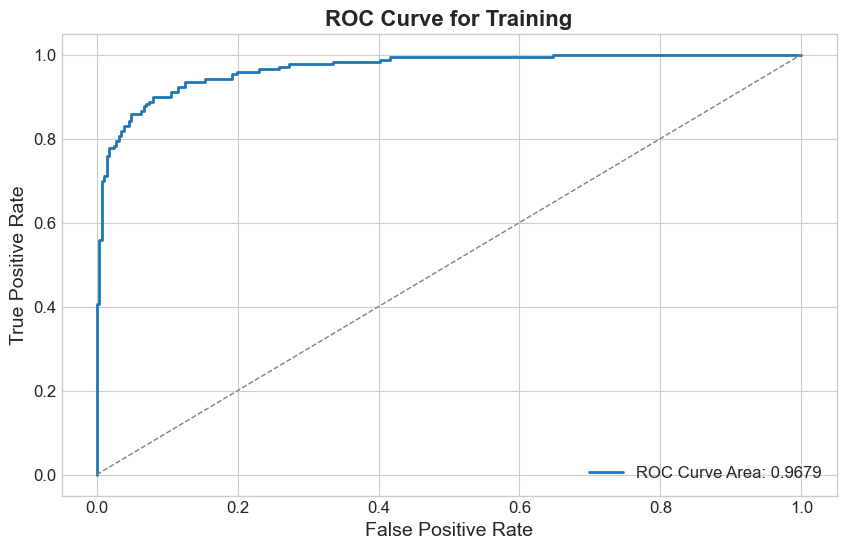

------------------------------------------------------------
Model Summary for Test
------------------------------------------------------------
Accuracy Score is: 0.8407


Confusion Matrix is: 
[[70  1]
 [17 25]]




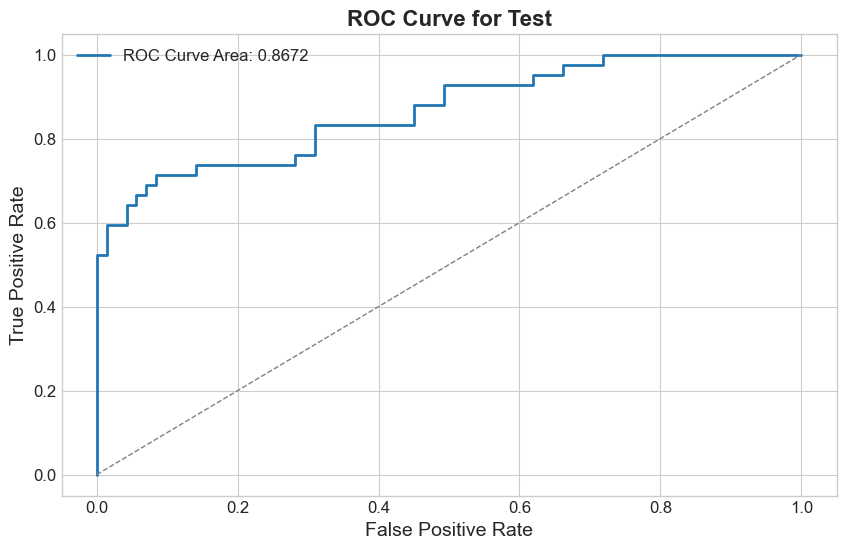

------------------------------------------------------------
Averaging all metrics
------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.888012   0.896900  0.888012  0.884116  0.950737
test      0.882301   0.894138  0.882301  0.877143  0.945920


,accuracy,precision,recall,f1-score,auc
training,0.888012,0.896900,0.888012,0.884116,0.950737
test,0.882301,0.894138,0.882301,0.877143,0.945920


In [223]:
# Specify the algorithm
algorithm_type = 'Unsupervised-KMeans'

# Perform Monte Carlo simulation and store results in the summary dataframe
summary['Unsupervised KMeans'] = run_monte_carlo_experiment(wdbc_data, 30, algorithm_type)

# Create a dataframe for the results of the specified algorithm
df = pd.DataFrame(summary['Unsupervised KMeans'])
df


#### iv. Spectral Clustering: 
i. Repeat 1(b)iii using spectral clustering, which is clustering based on kernels. Research what spectral clustering is. Use RBF kernel with gamma=1 or find a gamma for which the two clutsres have the same balance as the one in original data set (if the positive class has p and the negative class has n samples, the two clusters must have p and n members). Do not label data based on their proximity to cluster center, because spectral clustering may give you non-convex clusters . Instead, use fit − predict method.

Iteration: 1
Training Accuracy: 0.886
Testing Accuracy: 0.885
Iteration: 2
Training Accuracy: 0.8684
Testing Accuracy: 0.9204
Iteration: 3
Training Accuracy: 0.8925
Testing Accuracy: 0.8407
Iteration: 4
Training Accuracy: 0.8794
Testing Accuracy: 0.8761
Iteration: 5
Training Accuracy: 0.8838
Testing Accuracy: 0.8761
Iteration: 6
Training Accuracy: 0.8838
Testing Accuracy: 0.8761
Iteration: 7
Training Accuracy: 0.8728
Testing Accuracy: 0.8938
Iteration: 8
Training Accuracy: 0.8838
Testing Accuracy: 0.8496
Iteration: 9
Training Accuracy: 0.886
Testing Accuracy: 0.8496
Iteration: 10
Training Accuracy: 0.8772
Testing Accuracy: 0.8761
Iteration: 11
Training Accuracy: 0.8904
Testing Accuracy: 0.8496
Iteration: 12
Training Accuracy: 0.8794
Testing Accuracy: 0.8938
Iteration: 13
Training Accuracy: 0.8794
Testing Accuracy: 0.8938
Iteration: 14
Training Accuracy: 0.8794
Testing Accuracy: 0.885
Iteration: 15
Training Accuracy: 0.8925
Testing Accuracy: 0.8053
Iteration: 16
Training Accuracy: 0.872

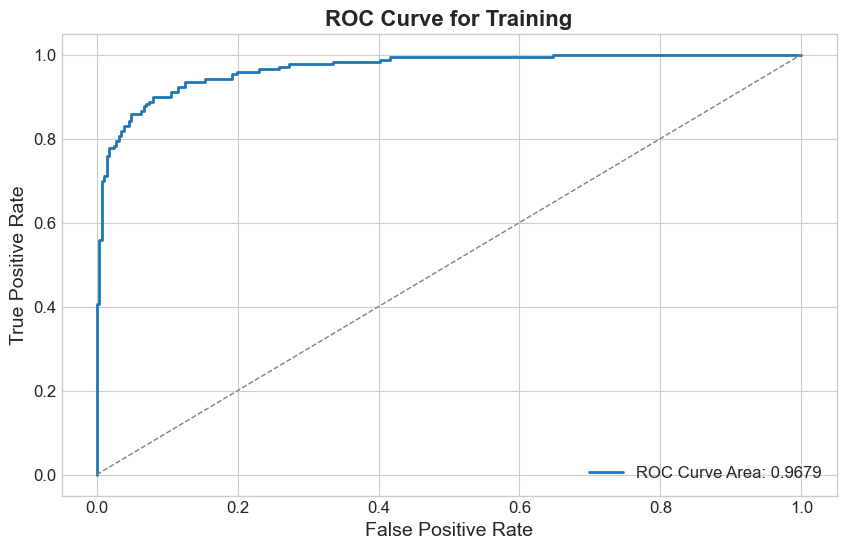

------------------------------------------------------------
Model Summary for Test
------------------------------------------------------------
Accuracy Score is: 0.823


Confusion Matrix is: 
[[69  2]
 [18 24]]




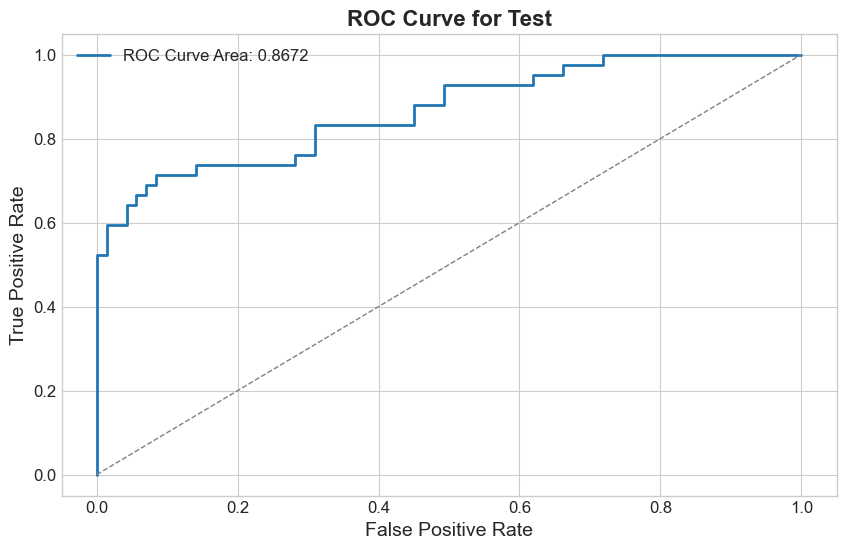

------------------------------------------------------------
Averaging all metrics
------------------------------------------------------------
          accuracy  precision    recall  f1-score       auc
training  0.882895   0.893003  0.882895  0.878464  0.950147
test      0.871681   0.885106  0.871681  0.865377  0.945257


,accuracy,precision,recall,f1-score,auc
training,0.882895,0.893003,0.882895,0.878464,0.950147
test,0.871681,0.885106,0.871681,0.865377,0.945257


In [224]:
algorithm_type = 'Unsupervised-Spectral'
summary['Unsupervised-Spectral'] = run_monte_carlo_experiment(wdbc_data, 30, algorithm_type)
df = pd.DataFrame(summary['Unsupervised-Spectral'])
df


#### v. One can expect that supervised learning on the full data set works better than semi-supervised learning with half of the data set labeled.One can expect that unsupervised learning underperforms in such situations. Compare the results you obtained by those methods.

In [225]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [226]:
from tabulate import tabulate

def summarization(summary):
    for summ in summary.keys():
        print('\n')
        print('='*60)
        print(summ)
        print('='*60)
        print(tabulate(summary[summ], headers='keys', tablefmt='grid'))


summarization(summary)





Supervized L1 SVM
+----------+----------+-------------+----------+------------+----------+
|          |      acc |   precision |   recall |   f1-score |      auc |
+==========+==========+=============+==========+============+==========+
| training | 0.98443  |    0.984458 | 0.98443  |   0.984413 | 0.998757 |
+----------+----------+-------------+----------+------------+----------+
| test     | 0.957817 |    0.958309 | 0.957817 |   0.957696 | 0.98891  |
+----------+----------+-------------+----------+------------+----------+


Semi-Supervised L1 SVM
+----------+----------+-------------+----------+------------+----------+
|          |      acc |   precision |   recall |   f1-score |      auc |
+==========+==========+=============+==========+============+==========+
| training | 0.984942 |    0.984971 | 0.984942 |   0.984921 | 0.998857 |
+----------+----------+-------------+----------+------------+----------+
| test     | 0.961947 |    0.962529 | 0.961947 |   0.961797 | 0.98912  |
+-----

#### Findings
**Based on the displayed results, it is evident that the Supervised learning approach demonstrates superior performance compared to the Semi-Supervised approach, and similarly, the Semi-Supervised approach surpasses the Unsupervised approach. However, the discernible performance gap is more prominent between the Semi-Supervised and Unsupervised approaches than between the Supervised and Semi-Supervised approaches. This trend is anticipated, given that the Supervised approach benefits from a larger pool of labeled data for prediction, whereas the Semi-Supervised approach has access to only a subset of labeled data. In contrast, the Unsupervised approach relies on feature similarity for predictions, explaining its comparatively lower performance than both the Supervised and Semi-Supervised approaches.**

### 2. Active Learning Using Support Vector Machines

#### (a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.


In [227]:
banknote_data = "../data/HW8_data/data_banknote_authentication.txt"
banknote_data = pd.read_csv(banknote_data, header=None)
banknote_data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
banknote_data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [228]:
banknote_data['class'].value_counts()

0    762
1    610
Name: class, dtype: int64

In [229]:
# This function randomly splits the data into training and testing sets
def random_split():    
    train_dp = 900 # Number of data points in the training set
    test_dp = 472 # Number of data points in the testing set

    # Randomly choose the indices for the testing set
    test_idx = np.random.choice(banknote_data.shape[0], test_dp, replace=False)

    # Create a list of indices for the training set
    temp_list = []
    for i in range(banknote_data.shape[0]):
        if i not in test_idx:
            temp_list.append(i);

    # Convert the list to a numpy array and return the indices for the training and testing sets
    train_idx = np.array(temp_list)
    return {
        'train_idx': train_idx,
        'test_idx': test_idx,
    }

# Call the random_split() function and use the indices to select the corresponding rows from the data
index = random_split()
banknote_train = banknote_data.iloc[index['train_idx']] # Select rows for the training set
banknote_test = banknote_data.iloc[index['test_idx']] # Select rows for the testing set


In [230]:
banknote_train

,variance,skewness,curtosis,entropy,class
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
5,4.36840,9.67180,-3.9606,-3.16250,0
7,2.09220,-6.81000,8.4636,-0.60216,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [231]:
banknote_test

,variance,skewness,curtosis,entropy,class
989,-6.75260,8.81720,-0.061983,-3.72500,1
765,-3.84830,-12.80470,15.682400,-1.28100,1
1036,-2.38980,-0.78427,3.014100,0.76205,1
268,0.92970,-3.79710,4.642900,-0.29570,0
1106,-0.12690,-1.15050,-0.951380,0.57843,1
...,...,...,...,...,...
1360,-0.24745,1.93680,-2.469700,-0.80518,1
274,5.27560,0.13863,0.121380,1.14350,0
509,-0.29510,9.04890,-0.527250,-2.07890,0
930,-2.22140,-0.23798,0.560080,0.05602,1


#### (b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

#### i. Train a SVM with a pool of 10 randomly selected datapoints from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation.4 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [233]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def extend_used_indices(to_use_indices, used_indices, num_samples=10):
    np.random.shuffle(to_use_indices)
    pool, to_use_indices = to_use_indices[:num_samples], to_use_indices[num_samples:]
    used_indices.extend(pool)
    return used_indices, to_use_indices

def custom_active_learning(training_features, training_labels, testing_features, testing_labels, algorithm_settings):
    to_use_indices = np.arange(training_features.shape[0])
    used_indices = []
    accuracy_list = []

    while len(used_indices) <= 900:
        used_indices, to_use_indices = extend_used_indices(to_use_indices, used_indices)

        used_training_features, used_training_labels = training_features.iloc[used_indices], training_labels.iloc[used_indices]

        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **algorithm_settings)
        clf.fit(used_training_features, used_training_labels)

        test_predicted_labels = clf.predict(testing_features)
        test_report = classification_report(testing_labels, test_predicted_labels, output_dict=True)

        accuracy_list.append(test_report['accuracy'])

        if len(to_use_indices) == 0:
            break

        distances = clf.decision_function(training_features.iloc[to_use_indices])
        sorted_arg = np.arange(len(to_use_indices))
        sorted(sorted_arg, key=lambda i : abs(distances[i]))
        to_use_indices = to_use_indices[sorted_arg]
        used_indices, to_use_indices = extend_used_indices(to_use_indices, used_indices)

    return accuracy_list


In [235]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def extend_used_indices(to_use_indices, used_indices, num_samples=10):
    np.random.shuffle(to_use_indices)
    pool, to_use_indices = to_use_indices[:num_samples], to_use_indices[num_samples:]
    used_indices.extend(pool)
    return used_indices, to_use_indices

def custom_passive_learning(training_features, training_labels, testing_features, testing_labels, algorithm_settings):
    to_use_indices = np.arange(training_features.shape[0])
    used_indices = []
    accuracy_list = []

    while len(to_use_indices) > 0:
        used_indices, to_use_indices = extend_used_indices(to_use_indices, used_indices)

        used_training_features, used_training_labels = training_features.iloc[used_indices], training_labels.iloc[used_indices]

        clf = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **algorithm_settings)
        clf.fit(used_training_features, used_training_labels)

        test_predicted_labels = clf.predict(testing_features)
        test_report = classification_report(testing_labels, test_predicted_labels, output_dict=True)

        accuracy_list.append(test_report['accuracy'])

    return accuracy_list


In [236]:
def monte_carlo_algo_learning(data, n, algo):
    # Define hyperparameters for the SVM model
    tuned_params = {'C': np.logspace(-2, 7, 20)}
    
    # Define common settings for grid search
    kwargs = {
        'param_grid': tuned_params,
        'scoring': 'f1_weighted',
        'n_jobs': -1,
        'verbose': 0
    }
    
    # Initialize a list to store learning curves across iterations
    learning_curve = []
    
    # Loop through the specified number of iterations
    for i in range(n):
        # Split the data into training and test sets using a custom function
        index = random_split()
        train_idx = index['train_idx']
        test_idx = index['test_idx']
        train_set, test_set = data.iloc[train_idx], data.iloc[test_idx]
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        trainX, testX = scale_data(trainX, testX)
        kwargs['cv'] = StratifiedKFold(5, random_state=i, shuffle=True)
        
        # Execute the specified algorithm
        if algo == 'passive':
            # Passive learning
            acc_list = custom_passive_learning(trainX, trainY, testX, testY, kwargs)
            learning_curve.append(acc_list)
        elif algo == 'active':
            # Active learning
            acc_list = custom_active_learning(trainX, trainY, testX, testY, kwargs)
            learning_curve.append(acc_list)
        
#         # Print the test accuracy for the first and last batches of samples
#         print(f"Iteration {i + 1} | Test accuracy (10 samples): {round(acc_list[0], 4)} | Test accuracy (900 samples): {round(acc_list[-1], 4)}")
    
        print(f'Iteration: {i + 1}')
        print(f'Test accuracy (10 samples): {round(acc_list[0], 4)}')
        print(f'Test accuracy (900 samples): {round(acc_list[-1], 4)}')
        print("=====================================================")
              
    # Calculate the mean of the learning curves across iterations
    learning_curve = np.array(learning_curve)
    learning_curve = np.mean(learning_curve, axis=0)
    return learning_curve



In [237]:
# Specify the number of iterations and the algorithm
iterations = 50
algo = 'passive'

# Execute Monte Carlo simulation for the specified algorithm and store the learning curve
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    passive_learning_curve = monte_carlo_algo_learning(banknote_data, iterations, algo)


Iteration: 1
Test accuracy (10 samples): 0.8496
Test accuracy (900 samples): 0.9979
Iteration: 2
Test accuracy (10 samples): 0.9131
Test accuracy (900 samples): 0.9915
Iteration: 3
Test accuracy (10 samples): 0.8263
Test accuracy (900 samples): 0.9936
Iteration: 4
Test accuracy (10 samples): 0.9258
Test accuracy (900 samples): 0.9958
Iteration: 5
Test accuracy (10 samples): 0.8326
Test accuracy (900 samples): 0.9915
Iteration: 6
Test accuracy (10 samples): 0.7733
Test accuracy (900 samples): 0.9958
Iteration: 7
Test accuracy (10 samples): 0.8835
Test accuracy (900 samples): 0.9936
Iteration: 8
Test accuracy (10 samples): 0.6419
Test accuracy (900 samples): 0.9979
Iteration: 9
Test accuracy (10 samples): 0.9195
Test accuracy (900 samples): 0.9936
Iteration: 10
Test accuracy (10 samples): 0.9746
Test accuracy (900 samples): 0.9915
Iteration: 11
Test accuracy (10 samples): 0.8559
Test accuracy (900 samples): 0.9936
Iteration: 12
Test accuracy (10 samples): 0.8898
Test accuracy (900 sample

#### ii. Train a SVM with a pool of 10 randomly selected data points from the training set 5 using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM6 and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [238]:
iterations = 50
algo = 'active'
active_learning_curve = monte_carlo_algo_learning(banknote_data, iterations, algo)

Iteration: 1
Test accuracy (10 samples): 0.9597
Test accuracy (900 samples): 0.9958
Iteration: 2
Test accuracy (10 samples): 0.5636
Test accuracy (900 samples): 0.9915
Iteration: 3
Test accuracy (10 samples): 0.9915
Test accuracy (900 samples): 0.9936
Iteration: 4
Test accuracy (10 samples): 0.8432
Test accuracy (900 samples): 0.9979
Iteration: 5
Test accuracy (10 samples): 0.839
Test accuracy (900 samples): 0.9894
Iteration: 6
Test accuracy (10 samples): 0.9703
Test accuracy (900 samples): 0.9873
Iteration: 7
Test accuracy (10 samples): 0.8898
Test accuracy (900 samples): 0.9958
Iteration: 8
Test accuracy (10 samples): 0.9788
Test accuracy (900 samples): 0.9936
Iteration: 9
Test accuracy (10 samples): 0.9703
Test accuracy (900 samples): 0.9936
Iteration: 10
Test accuracy (10 samples): 0.8496
Test accuracy (900 samples): 0.9936
Iteration: 11
Test accuracy (10 samples): 0.7055
Test accuracy (900 samples): 0.9979
Iteration: 12
Test accuracy (10 samples): 0.8686
Test accuracy (900 samples

#### (c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

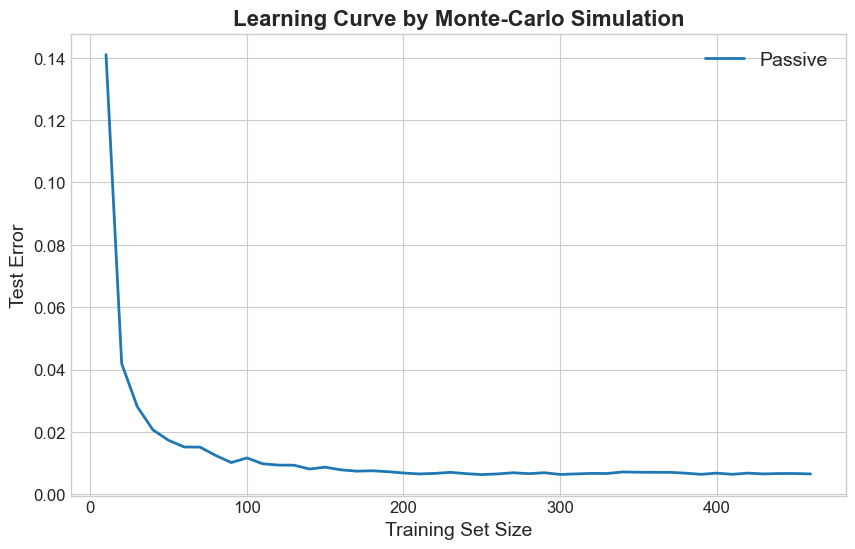

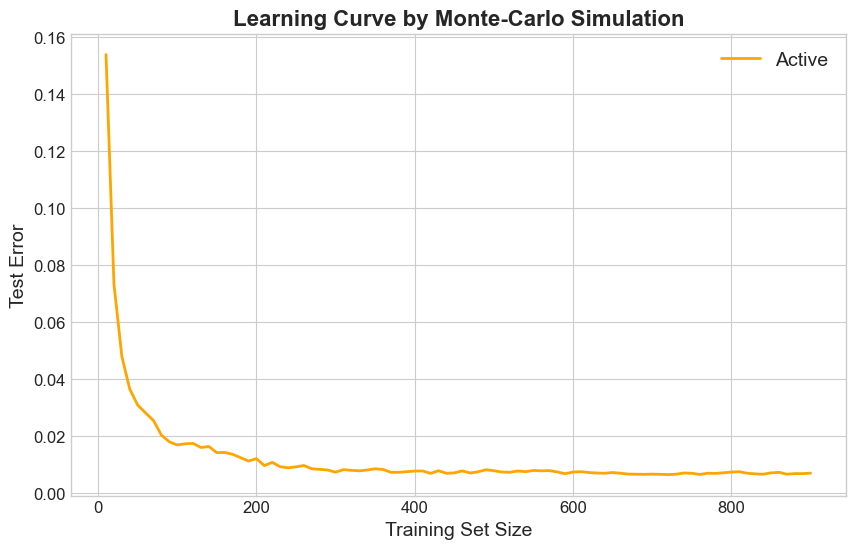

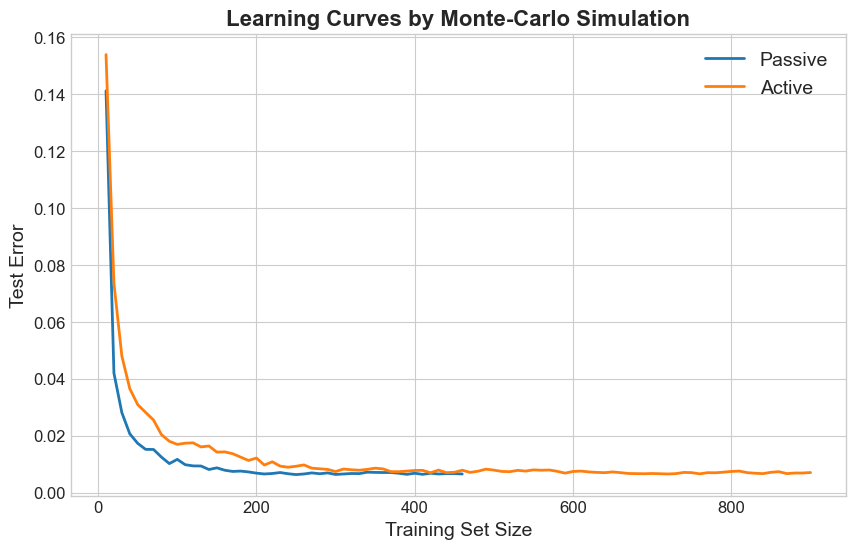

In [240]:
def plot_learning_curve(active, passive):
    

    # Set the style for the plot
    plt.style.use('seaborn-whitegrid')

    # Create a figure and axis
    fig, axes = plt.subplots(figsize=(10, 6))

    # Set the title of the plot
    axes.set_title("Learning Curve by Monte-Carlo Simulation", fontsize=16, fontweight='bold')

    # Generate x-axis values (training set sizes)
    x = 10 * np.arange(1, 91)

    # Plot the learning curve for passive learning
    axes.plot(x[:len(passive)], 1 - passive, label='Passive', linewidth=2)

    # Set labels for x and y axes
    axes.set_xlabel("Training Set Size", fontsize=14)
    axes.set_ylabel("Test Error", fontsize=14)

    # Set tick parameters for both axes
    axes.tick_params(axis='both', labelsize=12)

    # Add a legend to the plot
    axes.legend(fontsize=14)

    # Display the plot for passive learning
    plt.show()

    # Create a new figure and axis for active learning
    fig, axes = plt.subplots(figsize=(10, 6))

    # Set the title of the plot for active learning
    axes.set_title("Learning Curve by Monte-Carlo Simulation", fontsize=16, fontweight='bold')

    # Plot the learning curve for active learning
    axes.plot(x[:len(active)], 1 - active, label='Active', linewidth=2, color='orange')

    # Set labels for x and y axes
    axes.set_xlabel("Training Set Size", fontsize=14)
    axes.set_ylabel("Test Error", fontsize=14)

    # Set tick parameters for both axes
    axes.tick_params(axis='both', labelsize=12)

    # Add a legend to the plot
    axes.legend(fontsize=14)

    # Display the plot for active learning
    plt.show()

    # Create a third figure and axis for both curves together
    fig, axes = plt.subplots(figsize=(10, 6))

    # Set the title of the combined plot
    axes.set_title("Learning Curves by Monte-Carlo Simulation", fontsize=16, fontweight='bold')

    # Plot both learning curves together
    axes.plot(x[:len(passive)], 1 - passive, label='Passive', linewidth=2)
    axes.plot(x[:len(active)], 1 - active, label='Active', linewidth=2)

    # Set labels for x and y axes
    axes.set_xlabel("Training Set Size", fontsize=14)
    axes.set_ylabel("Test Error", fontsize=14)

    # Set tick parameters for both axes
    axes.tick_params(axis='both', labelsize=12)

    # Add a legend to the combined plot
    axes.legend(fontsize=14)

    # Display the plot for both learning curves together
    plt.show()

# Plot the learning curve for passive learning
plot_learning_curve(passive_learning_curve, active_learning_curve)


#### Findings:
**Active learning involves the strategic selection of data points for label acquisition, aiming to enhance model accuracy with a limited number of labeled examples.   
In contrast, passive learning utilizes all available labeled data without employing any specific selection strategy.  
The utilization of active learning contributes to improved model performance by prioritizing the labeling of the most informative examples. This approach results in a more diverse and representative set of labeled data, mitigating the risk of overfitting and minimizing the impact of noisy labels on the model's training process.**